### Исследование объявлений о продаже квартир. 

В распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import numpy as np
from termcolor import colored
import matplotlib.pyplot as plt

In [3]:
df_borrowers_reliability = pd.read_csv('/datasets/data.csv')

display(df_borrowers_reliability.head())
df_borrowers_reliability.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод

Рассмотрим полученную информацию подробнее.

Всего в таблице 12 столбцов, тип данных столбцов различен.

Подробно разберём, какие в df_borrowers_reliability столбцы и какую информацию о заёмщике они содержат:

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

Количество значений в столбцах различается. Это говорит о том, что в данных есть пропущенные значения.

### Шаг 2. Предобработка данных

### Обработка пропусков в столбце days_employed

In [4]:
count_people_without_experience = df_borrowers_reliability[df_borrowers_reliability['days_employed'] == 0].days_employed.count()
print(count_people_without_experience, ' - Количество людей без опыта работы')
df_borrowers_reliability['days_employed'] = df_borrowers_reliability['days_employed'].fillna(0)

0  - Количество людей без опыта работы


### Обработка пропусков в столбце total_income

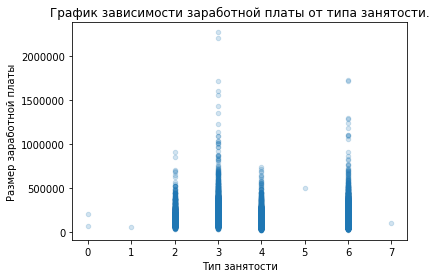

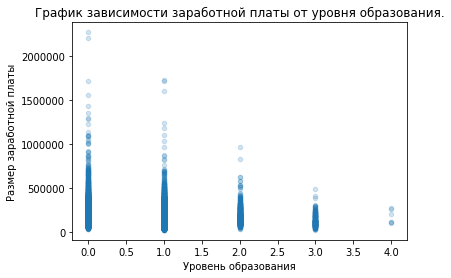

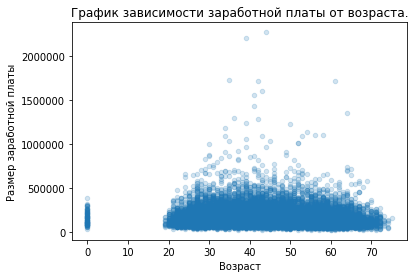

In [5]:
df_borrowers_reliability['income_type_id'] = df_borrowers_reliability['income_type'].astype('category')
cat_columns = df_borrowers_reliability.select_dtypes(['category']).columns
df_borrowers_reliability['income_type_id'] = df_borrowers_reliability[cat_columns].apply(lambda x: x.cat.codes)

df_borrowers_reliability.plot(kind='scatter',x='income_type_id', y='total_income',alpha=0.2)
plt.title("График зависимости заработной платы от типа занятости.")
plt.xlabel("Тип занятости")
plt.ylabel("Размер заработной платы")

df_borrowers_reliability.plot(kind='scatter',x='education_id',y='total_income',alpha=0.2)
plt.title("График зависимости заработной платы от уровня образования.")
plt.xlabel("Уровень образования")
plt.ylabel("Размер заработной платы")

df_borrowers_reliability.plot(kind='scatter',x='dob_years', y='total_income',alpha=0.2)
plt.title("График зависимости заработной платы от возраста.")
plt.xlabel("Возраст")
plt.ylabel("Размер заработной платы")

mean_dob_years = df_borrowers_reliability.groupby('dob_years')['total_income'].mean()
mean_income_type = df_borrowers_reliability.groupby('income_type')['total_income'].mean()
mean_education_id = df_borrowers_reliability.groupby('education_id')['total_income'].mean()

def calculate_replacement_value(row):
    return (mean_dob_years[row['dob_years']] + mean_income_type[row['income_type']] + mean_education_id[row['education_id']]) / 3

df_borrowers_reliability['total_income'] = df_borrowers_reliability.apply(calculate_replacement_value, axis=1)

### Вывод

* Было обнаружено, что данные о трудовом стаже и ежемесячном доходе 2174 человек неизвестны. 
* Считаю, что возможные причины появления пропусков в данных:
    * Отсутствие опыта как такового, так как в таблице нет людей с нулевым стажем, то кто-то из 2174 людей может не иметь работы; 
    * Кто-то из людей с пропусками может не желать раскрывать данные о своей работе. 
* Пропуски заполнены по следующему принципу:    
    * По причине не влияния данных из столбца трудового стажа на дальнейшие исследования, заменил их на уникальное значение в данном наборе данных "0"; 
    * В случае столбца "total_income" его значения важны для дальнейшего исследования, поэтому необходимо заменить пропущенные значения максимально корректно. По этой причине была выдвинута гипотеза, о том, что на размер заработной платы влияет возраст, уровень образования, тип занятости. Проанализировав графики связей этих факторов с размером зарплаты гипотеза была подтверждена. И в случае пропуска заработной платы, они заменяются средним между средних зарплат для каждой группы (возраст, уровень образования, тип занятости).

### Обработка артефактов

In [6]:
display(df_borrowers_reliability["children"].value_counts())
df_borrowers_reliability["children"] = df_borrowers_reliability["children"].replace({-1: 1, 20: 2})
display(df_borrowers_reliability["children"].value_counts())

def change_invalid_age(row):
    if row["days_employed"] < 0:
        return abs(row["days_employed"])
    return row["days_employed"] / 24

try:
    print(df_borrowers_reliability["days_employed"].min(), df_borrowers_reliability[df_borrowers_reliability
    [df_borrowers_reliability["days_employed"]<0]["days_employed"].max() == df_borrowers_reliability["days_employed"]]
    ["days_employed"].values[0], "Диапазон стажа в отрицательной области.")
    
    print(df_borrowers_reliability[df_borrowers_reliability[df_borrowers_reliability["days_employed"] > 0]["days_employed"]
    .min()== df_borrowers_reliability["days_employed"]]["days_employed"],df_borrowers_reliability["days_employed"].max()
    , "Диапазон стажа в положительной области.")
    
    df_borrowers_reliability["days_employed"] = df_borrowers_reliability.apply(change_invalid_age, axis=1)
except:
    display('Уже изменены некорректные значения возраста')
    
display(df_borrowers_reliability["dob_years"].unique())

try:
    display(df_borrowers_reliability["purpose"].value_counts())
except:
    display('Уже удален столбец purpose')    

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

-18388.949900568383 -24.14163324048118 Диапазон стажа в отрицательной области.
20444    328728.720605
Name: days_employed, dtype: float64 401755.40047533 Диапазон стажа в положительной области.


array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

### Вывод

* children - аномальные значения -1, 20:
    * -1 поменял на 1, полагая, что случайно нажат -;
    * 20 на 2, предположив, что ноль был нажат случайно.
* days_employed - аномальные значения отрицательный стаж, огромные положительные значения:
    * Однако сами значения отрицательного стажа по модулю весьма реальные, значения располагаются в диапазоне примерно -50 лет - -24 дня, число -50 лет не смущает по причине того, что стаж может идти с повышающим коэффициентом;
    * Положительные значения аномально велики примерно 56 - 900 лет, в связи с чем было предположено, что положительные значения задают стаж не в днях, а в часах и разделены на 24 вновь получившийся диапазон - 2.3 года - 37.5 лет, предполагая что стаж может идти с повышающим коэффициентом 37.5 года не кажется аномально большим значением.
* dob_years - 0 не считаю аномальным значением, потому что заемщик может просто скрывать возраст


### Замена типа данных

In [7]:
print("столбец - total_income, тип - ", df_borrowers_reliability.dtypes["total_income"]
       , "\nстолбец - days_employed, тип - ", df_borrowers_reliability.dtypes["days_employed"])

df_borrowers_reliability["total_income"] = df_borrowers_reliability["total_income"].astype(int)
df_borrowers_reliability["days_employed"] = df_borrowers_reliability["days_employed"].astype(int)

print("столбец - total_income, тип - ", df_borrowers_reliability.dtypes["total_income"]
       , "\nстолбец - days_employed, тип - ", df_borrowers_reliability.dtypes["days_employed"])

столбец - total_income, тип -  float64 
столбец - days_employed, тип -  float64
столбец - total_income, тип -  int64 
столбец - days_employed, тип -  int64


### Вывод

total_income, days_employed - значения типа float64, перед заменой необходимо заменить пропущенные значения, но это было сделано предварительно, выбираю astype как подходящую функцию для этой задачи.

### Обработка дубликатов

In [8]:
print(colored("{} - Количество дубликатов до приведения значений к нижнему регистру.".format(df_borrowers_reliability.
              duplicated().sum()), "red"))

print(colored(df_borrowers_reliability["education"].unique(), "red"))
df_borrowers_reliability["education"] = df_borrowers_reliability["education"].str.lower()

print(colored("{} - Количество дубликатов после приведения значений к нижнему регистру.".format(df_borrowers_reliability.
              duplicated().sum()), "blue"))    
print(colored(df_borrowers_reliability["education"].unique(), "blue"))

df_borrowers_reliability = df_borrowers_reliability.drop_duplicates().reset_index(drop=True)

print(colored("{} - Проверка отсутствия дубликатов.".format(df_borrowers_reliability.
              duplicated().sum()), "magenta"))

54 - Количество дубликатов до приведения значений к нижнему регистру.
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
71 - Количество дубликатов после приведения значений к нижнему регистру.
['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
0 - Проверка отсутствия дубликатов.


### Вывод

Столбец education - различное использование регистра плодит дубликаты, которые не детектируются методом duplicates в связи с чем привожу к нижнему регистру все значения столбца и обновляю количество найденных дубликатов. Да, существовали записи о клиентах отличающиеся лишь регистром значений в столбце education. После приведения значений к одному регистру выполнил замену дубликатов функцией drop_duplicates. Полагаю, что могут быть и дубликаты по последнему столбцу, но лемматизация в следующем пункте.
Предполагаемые причины возникновения дубликатов:
* Покупка в кредит нескольких изделий одной и той же стоимости;
* Сбой при обработке значений;
* Ошибка оператора, создававшего заявку на кредит;
* Клиенты с одинаковыми параметрами, взявшие кредит на одинаковую цель.


### Лемматизация

#### Вспомогательные функции

In [9]:
from pymystem3 import Mystem
module_for_lemmas = Mystem()

def aggregate_purpose(goals_lemmas):
    if ('жилье' in goals_lemmas) or ('недвижимость' in goals_lemmas):
        return 'операции с недвижимостью'
            
    if 'образование' in goals_lemmas:
        return 'повышение образованности'
            
    if 'свадьба' in goals_lemmas:
        return 'организация свадьбы'   
            
    return 'действия с автомобилем'

def generate_aggregated_df(purposes_array):
    values_for_df = []
    
    for purpose in purposes_array:
        lemmas = module_for_lemmas.lemmatize(purpose)
        values_for_df.append(aggregate_purpose(lemmas))
    
    upgrades_purposes_df = pd.DataFrame(values_for_df, index=purposes_array)

    return upgrades_purposes_df

#### Итоговая агрегация целей кредитования 

In [10]:
try:
    unique_purposes = df_borrowers_reliability.purpose.unique()
    aggregated_df_purposes = generate_aggregated_df(unique_purposes)
    df_borrowers_reliability['aggregated_purpose'] = df_borrowers_reliability['purpose'].map(dict(aggregated_df_purposes[0]))

except:
    print('столбец purpose уже удален')
    

### Вывод

Различных значений целей кредита в исходном наборе данных 38 штук, однако уникальных значений меньше, мною были выделены следующие:
* Повышение образованности;
* Операции с недвижимостью;
* Действия с автомобилем;
* Организация свадьбы.

Затем используя все встречающиеся уникальные значения столбца "purpose" был создан "Data Frame" "aggregated_df_purposes", который в соответствие каждому значению из столбца "purpose" ставит в соответствие выделенные мною уникальные значения целей. Этот массив был создан, чтобы многократно для каждого значения исходного набора данных не генерировать значение столбца "purpose". Затем был создан столбец с обновленными целями.

### Проверка на дубликаты после лемматизации

In [11]:
try:
    df_borrowers_reliability = df_borrowers_reliability.drop(['purpose'], axis=1)
    print(df_borrowers_reliability.duplicated().sum(), " - Дубликатов после получения обобщенных целей.")
    
except:
    display("Уже удален.")
    
df_borrowers_reliability = df_borrowers_reliability.drop_duplicates().reset_index(drop=True)
print(df_borrowers_reliability.duplicated().sum(), " - Проверка удаления дубликатов.")

345  - Дубликатов после получения обобщенных целей.
0  - Проверка удаления дубликатов.


### Вывод

После лемматизации и объединении целей в определенные группы были вновь найдены повторы, расправился и с ними, вероятные причины их появления:
 * Несколько различных операторов, обрабатывающих данных, имевших разное представления об одной и той же цели наплодили клонов заемщиков;
 * Некорректная попытка изменения целей.

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

,mean,count
,debt,debt
children,,
0,0.076767,13821
1,0.092786,4796
2,0.095553,2114
3,0.082067,329
4,0.100000,40
5,0.000000,9


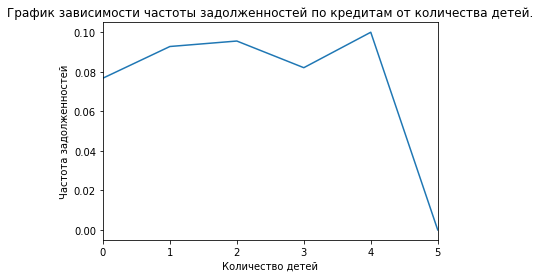

In [12]:
display(df_borrowers_reliability.pivot_table(index='children', values='debt', aggfunc=['mean','count']))

df_borrowers_reliability.groupby('children')['debt'].mean().plot()
plt.title("График зависимости частоты задолженностей по кредитам от количества детей.")
plt.xlabel("Количество детей")
plt.ylabel("Частота задолженностей");

### Вывод

Зависимости между количеством детей и возвратом кредита в срок нет, расхождение в частоте возвратов в срок у людей, имеющих детей от 0 до 4 пренебрежимо мало. А вот случай, наблюдаемый у людей с 5 детей интересен,являются ли такие заёмщике более благополучными? Однако на основе лишь 9 таких клиентов такой однозначный вывод сделать не представляется возможным.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

,mean,count
,debt,debt
family_status,,
Не женат / не замужем,0.098455,2783
в разводе,0.071249,1193
вдовец / вдова,0.066808,943
гражданский брак,0.094106,4123
женат / замужем,0.076987,12067


1.3431759479262488  - соотношение задолженностей людей не узаконивших свое семейное положения и тех, кто это сделал 


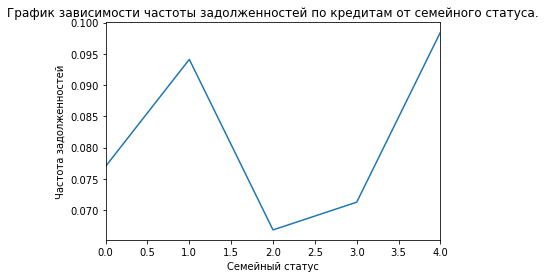

In [13]:
display(df_borrowers_reliability.pivot_table(index='family_status', values='debt', aggfunc=['mean','count']))
mean_debt_by_marital_status = df_borrowers_reliability.groupby('family_status')['debt'].mean()

difference_in_solvency =  (3 * (mean_debt_by_marital_status[0] + mean_debt_by_marital_status[3])) \
/ (2 * (mean_debt_by_marital_status[1] + mean_debt_by_marital_status[2] + mean_debt_by_marital_status[4]))

print(difference_in_solvency, " - соотношение задолженностей людей не узаконивших свое семейное положения и тех, кто это сделал ")

df_borrowers_reliability.groupby('family_status_id')['debt'].mean().plot()
plt.title("График зависимости частоты задолженностей по кредитам от семейного статуса.")
plt.xlabel("Семейный статус")
plt.ylabel("Частота задолженностей");

In [14]:
aggregated_purpose_pivot_table = df_borrowers_reliability.pivot_table(index='aggregated_purpose', 
                                                        values ='debt', aggfunc = ['mean','count'])
aggregated_purpose_pivot_table.style.format({( 'mean', 'debt'): '{:.2%}'})

,mean,count
,debt,debt
aggregated_purpose,,
действия с автомобилем,9.41%,4271
операции с недвижимостью,7.39%,10569
организация свадьбы,8.07%,2305
повышение образованности,9.33%,3964


### Вывод

Зависимость между семейным положением и возвратом кредита в срок прослеживается, люди узаконившие свои отношения в среднем на 34% чаще не возвращают кредиты, чем люди, которые не делали этого. Особенно не платежеспособными клиентами оказываются люди, потерявшие своего супруга(у).

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [15]:
df_borrowers_reliability['total_income_anomaly'] = pd.cut(df_borrowers_reliability['total_income'],[0,61000,62000,80000,100000,130000,173000,200000,230000,500000,np.inf])
display(df_borrowers_reliability.groupby('total_income_anomaly')['debt'].agg(['mean','count']))

df_borrowers_reliability['total_income_10gr'] = pd.qcut(df_borrowers_reliability['total_income'], 10)
display(df_borrowers_reliability.pivot_table(index = 'total_income_10gr',values = 'debt', aggfunc=['mean','count']))

print(df_borrowers_reliability['debt'].mean(), " - среднее количество должников.")

,mean,count
total_income_anomaly,,
"(0.0, 61000.0]",NaN,0
"(61000.0, 62000.0]",NaN,0
"(62000.0, 80000.0]",NaN,0
"(80000.0, 100000.0]",NaN,0
"(100000.0, 130000.0]",0.000000,7
"(130000.0, 173000.0]",0.091969,13809
"(173000.0, 200000.0]",0.064326,7291
"(200000.0, 230000.0]",NaN,0
"(230000.0, 500000.0]",0.000000,2


,mean,count
,debt,debt
total_income_10gr,,
"(124806.999, 148938.0]",0.055398,2112
"(148938.0, 157103.0]",0.077823,2223
"(157103.0, 161097.0]",0.114783,2239
"(161097.0, 163816.0]",0.109478,1973
"(163816.0, 165566.0]",0.102326,2150
"(165566.0, 167477.0]",0.092918,1991
"(167477.0, 175365.0]",0.087470,2115
"(175365.0, 179580.0]",0.069372,2119


0.0823819224027666  - среднее количество должников.


### Вывод

Зависимость между уровнем дохода и возвратом кредита в срок существует. Имеются некоторые аномально отличающиеся по количеству должников ежемесячные доходы заёмщиков: 
* Из 50 человек, имеющих доход от 61000 до 62000 каждый седьмой кредит не вернул, что в среднем в два раза чаще;
* Из 4000 человек, имеющих доход от 150000 до 165000 каждый десятый кредит не вернул, что больше среднего на 25%.
В итоге самыми не благонадежными заёмщиками являются люди с доходом в диапазоне 130000 - 170000.

- Как разные цели кредита влияют на его возврат в срок?

In [16]:
display(df_borrowers_reliability.pivot_table(index='aggregated_purpose', values ='debt', aggfunc = ['mean','count']))
print(df_borrowers_reliability['debt'].mean(), " - среднее количество должников.")


,mean,count
,debt,debt
aggregated_purpose,,
действия с автомобилем,0.094123,4271
операции с недвижимостью,0.073895,10569
организация свадьбы,0.080694,2305
повышение образованности,0.093340,3964


0.0823819224027666  - среднее количество должников.


### Вывод

Разные цели кредита влияют на его возврат в срок:
* Берущие кредит для действий с автомобилем и повышения образования возвращают его реже;
* Люди производящие операции с недвижимостью возвращают кредит чаще всех;
* А количество взявших кредит на свадьбу и вернувших в срок располагается между двумя категориями выше. 

### Категоризация данных

In [17]:
df_borrowers_reliability['age_groups'] = pd.cut(df_borrowers_reliability['dob_years'], [-1,20,34,50,80])

display(df_borrowers_reliability.pivot_table(index = 'age_groups',values = 'debt', aggfunc=['mean','count']))
display(df_borrowers_reliability.pivot_table(index = 'education',values = 'debt', aggfunc=['mean','count']))

df_borrowers_reliability_categorized = df_borrowers_reliability[['aggregated_purpose', 'total_income_10gr', 'debt', 'family_status', 'education', 'age_groups']]

,mean,count
,debt,debt
age_groups,,
"(-1, 20]",0.078788,165
"(20, 34]",0.110370,5844
"(34, 50]",0.081339,8606
"(50, 80]",0.058670,6494


,mean,count
,debt,debt
education,,
высшее,0.053349,5211
начальное,0.109929,282
неоконченное высшее,0.091398,744
среднее,0.091618,14866
ученая степень,0.000000,6


### Вывод

Во время ответов на вопросы были выявлены столбцы, влияющие на платежеспособность заёмщиков. А в последнем поле code было выяснено, что люди из разных возрастных групп обладают разной платежеспособностью, а также, что люди без высшего образования внушают меньше доверия в возврате кредита. В связи с чем были выделены столбцы: 'aggregated_purpose', 'total_income_10gr', 'debt', 'family_status', 'education', 'age_groups' и из них создан новый набор данных. Значения каждого столбца существенно влияют на платежеспособность, поэтому столбцы и такие.

### Шаг 4. Общий вывод

Были выявлены следующие закономерности: уровень образования, дохода, принадлежность к определенным возрастным группам, семейный статус, цель получения кредита влияют на вероятность банком получить своевременно выплаты по кредиту, однако взаимосвязи между количеством детей и возвратом кредита в срок выявлено не было.

Были обнаружены пропуски в столбце "общий трудовой стаж в днях" замена производилась на нули, по причинам:
* Отсутствия людей без стажа;
* Предположения, что некоторые люди не хотели раскрывать стаж.

Пропуски были обнаружены и в столбце "ежемесячный доход":
* Была выдвинута гипотеза, что на размер заработной платы влияет возраст, уровень образования, тип занятости. Проанализировав графики связей этих факторов с размером зарплаты гипотеза была подтверждена. И в случае пропуска заработной платы, она заменялась средним между средних зарплат для каждой группы (возраст, уровень образования, тип занятости).

Также были выявлены дубликаты, причинами их возникновения считаю:
* Покупка в кредит нескольких изделий одной и той же стоимости одним человеком;
* Сбой при обработке значений;
* Ошибка оператора, создававшего заявку на кредит;
* Клиенты с одинаковыми параметрами, взявшие кредит на одинаковую цель;
* Несколько различных операторов, обрабатывающих данных, имевших разное представления об одной и той же цели наплодили клонов заемщиков;
* Некорректная попытка изменения целей.

Объединены мелкие цели кредитов в более крупные:
* Повышение образованности;
* Операции с недвижимостью;
* Действия с автомобилем;
* Организация свадьбы.

В результате исследования выявлены критерии для выявления способности потенциального заёмщика вернуть кредит банку. Найдены закономерности, исследование которых невозможно из-за недостатка определенных данных (платежеспособность людей с 5 детьми, с ученой степенью). На основе полученных данных возможно построение рекомендательной системы по оценке платежеспособности клиентов.